### Description
This notebook computes cloud feedbacks and mean-state cloud errors in an illustrative climate model (GFDL-CM4). It then compares them to the WCRP Assessment Values following Zelinka et al (2022).

### Input
- for feedback calculations: tas,rsdscs,rsuscs,wap,clisccp
- for ECS calculations: tas,rlut,rsut,rsdt
- flag to calculate ECS or to simply use the pre-computed values from https://github.com/mzelinka/cmip56_forcing_feedback_ecs 

### Output
- dictionaries containing cloud feedbacks and mean-state errors
- figures and tables from Zelinka et al (2022), highlighting the illustrative climate model, saved to https://github.com/mzelinka/assessed-cloud-fbks/tree/main/figures

### History
This code is updated from the v2.2 release (March 4, 2022):
  - all calls to CDAT functions replaced with xarray and xcdat
  - code refactored and cleaned up in a variety of places 
  - all of these changes are thanks to Li-Wei Chao (LLNL)

### References
- Zelinka et al. (2022): [Evaluating climate models’ cloud feedbacks against expert judgement](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JD035198), <em>J. Geophys. Res.</em>, 127, e2021JD035198, doi:10.1029/2021JD035198.
- Sherwood et al. (2020): [A combined assessment of Earth’s climate sensitivity](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2019RG000678), <em>Rev. Geophys.</em>, 58, e2019RG000678, doi:10.1029/2019RG000678.
    
### Contact
- Mark Zelinka (zelinka1@llnl.gov)

### User Input

In [1]:
model = 'GFDL-CM4'	
variant = 'r1i1p1f1'
path = '/p/css03/esgf_publish/CMIP6'

# Flag to compute ECS
# True: compute ECS using abrupt-4xCO2 run
# False: do not compute, instead rely on ECS value present in the json file (if it exists)
get_ecs = True#False

### Import useful functions

In [2]:
import cld_fbks_ecs_assessment_v3 as dataviz
import cal_CloudRadKernel_xr as CRK
import organize_jsons as OJ
import xsearch as xs
import xarray as xr
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

### Get filepaths based on user input

In [3]:
if get_ecs:
    exps = ['amip','amip-p4K','piControl','abrupt-4xCO2']
else:
    exps = ['amip','amip-p4K']

era = 'CMIP6' # user choice
filepath={}
for exp in exps:
    filepath[exp]={}
    if 'amip' in exp:
        variables = ['tas','rsdscs','rsuscs','wap','clisccp'] # necessary for cloud feedback calcs
    else:
        variables = ['tas', 'rlut', 'rsut', 'rsdt'] # needed for ECS calc
    
    for var in variables:
        filepath[exp][var]={}
        if var=='clisccp':
            table='CFmon'
        else:
            table='Amon'
        pathDict = xs.findPaths(exp, var, 'mon', mip_era=era, cmipTable=table, realm='atmos', model=model, member=variant)
        dpath=list(pathDict.keys())
        if len(dpath)==1:
            filepath[exp][var] = dpath[0]
        else:
            stop # need to investigate why more than one path survived...

### Do all the cloud feedback and error metric calculations

In [4]:
fbk_dict,obsc_fbk_dict,KEM_dict = CRK.CloudRadKernel(filepath) 

get data
amip
  tas
  rsdscs
  rsuscs
  wap
  clisccp
amip-p4K
  tas
  rsdscs
  rsuscs
  wap
  clisccp
get LW and SW kernel
Sort into omega500 bins
Compute Klein et al error metrics
Compute feedbacks
    for section ALL
    for section HI680
    for section LO680
Get Obscuration Terms


2023-09-28 12:23:00,845 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


Compute regional averages


### Add this model's results to the pre-existing json file containing other models' results

In [5]:
updated_fbk_dict,updated_obsc_fbk_dict = OJ.organize_fbk_jsons(fbk_dict,obsc_fbk_dict,model,variant)
updated_err_dict = OJ.organize_err_jsons(KEM_dict,model,variant)

### Compute ECS or grab it from pre-computed json file

In [6]:
ecs = None
if get_ecs:    
    # Calculate ECS and add it to the pre-existing json file containing other models' results.
    import compute_ECS_xr as CE
    pifilepath = filepath['piControl']
    abfilepath = filepath['abrupt-4xCO2']        
    x,y = CE.compute_abrupt_anoms(pifilepath,abfilepath)  
    erf,lam,ecs = CE.gregory_calcs(x,y)    
updated_ecs_dict = OJ.organize_ecs_jsons(ecs,model,variant)

### Plot this model alongside other models and expert assessment

CCSM4: Using Klein error metrics from r7i1p1 rather than r1i1p1
E3SM-1-0: Using ECS from r1i1p1f1 rather than r2i1p1f1
HadGEM3-GC31-LL: Using ECS from r1i1p1f3 rather than r5i1p1f3


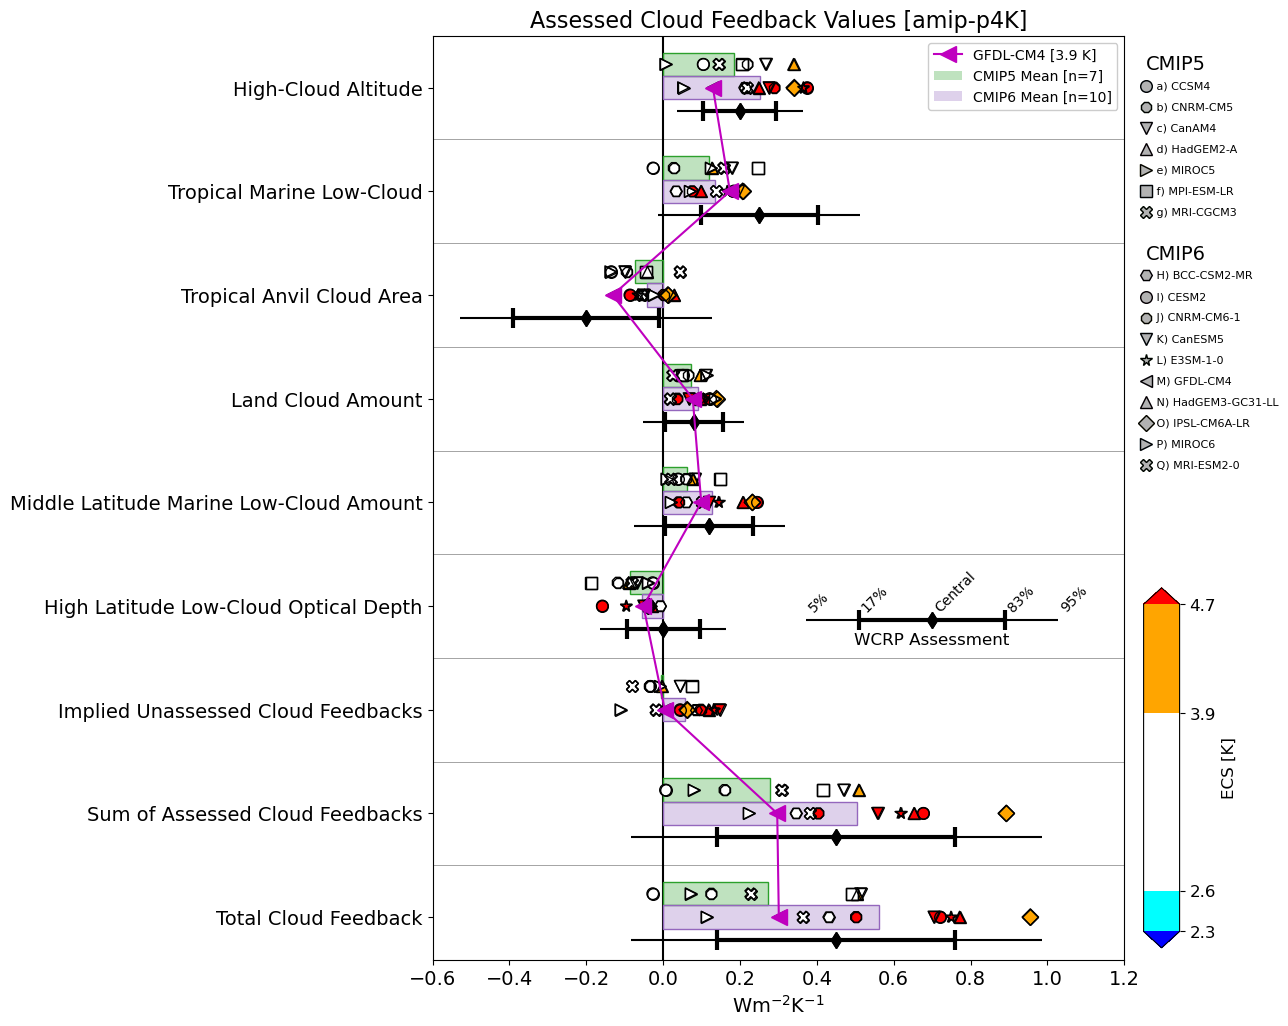

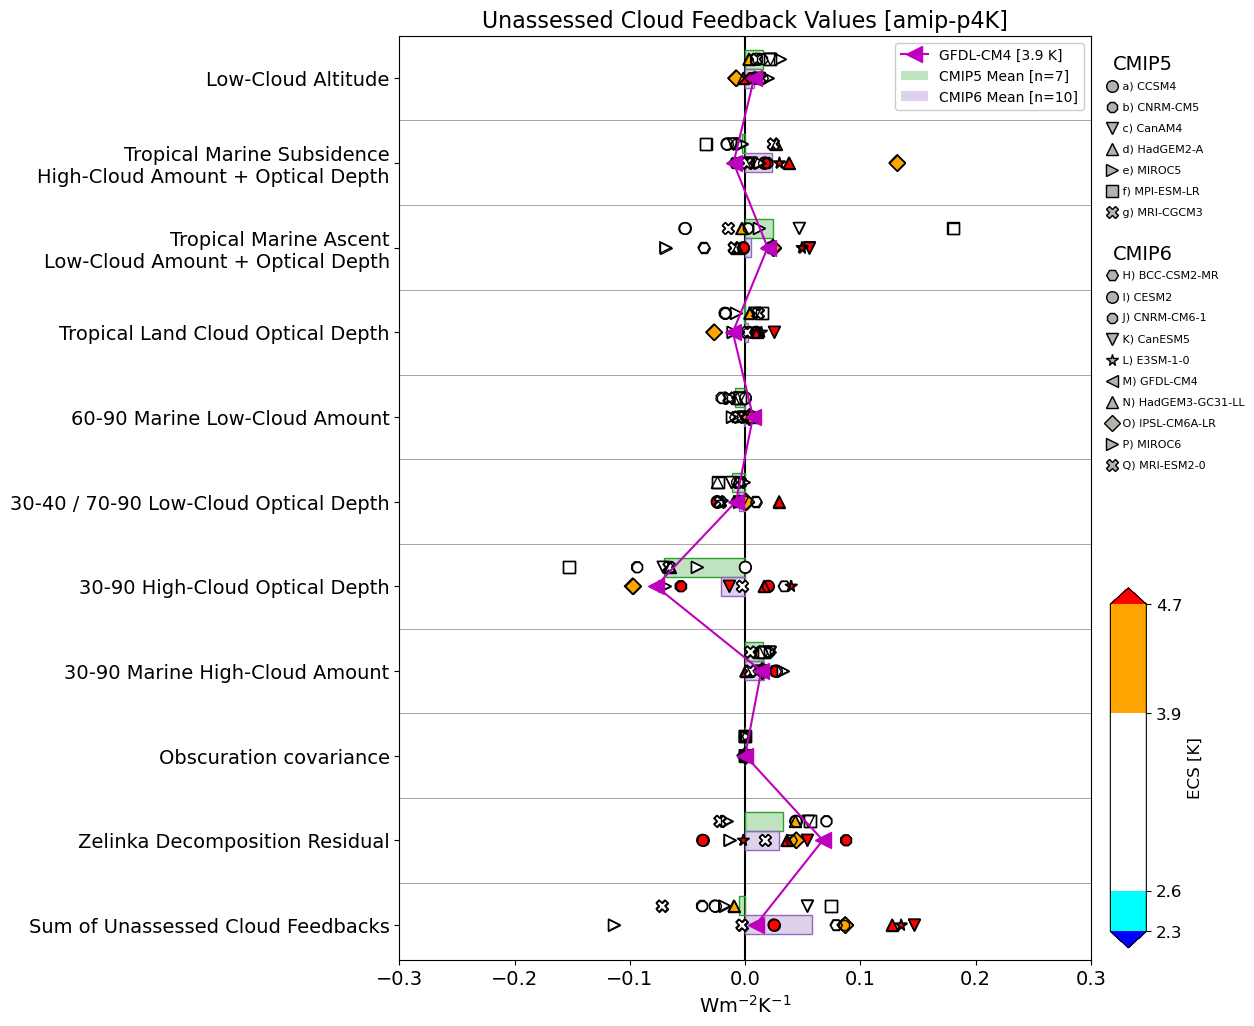

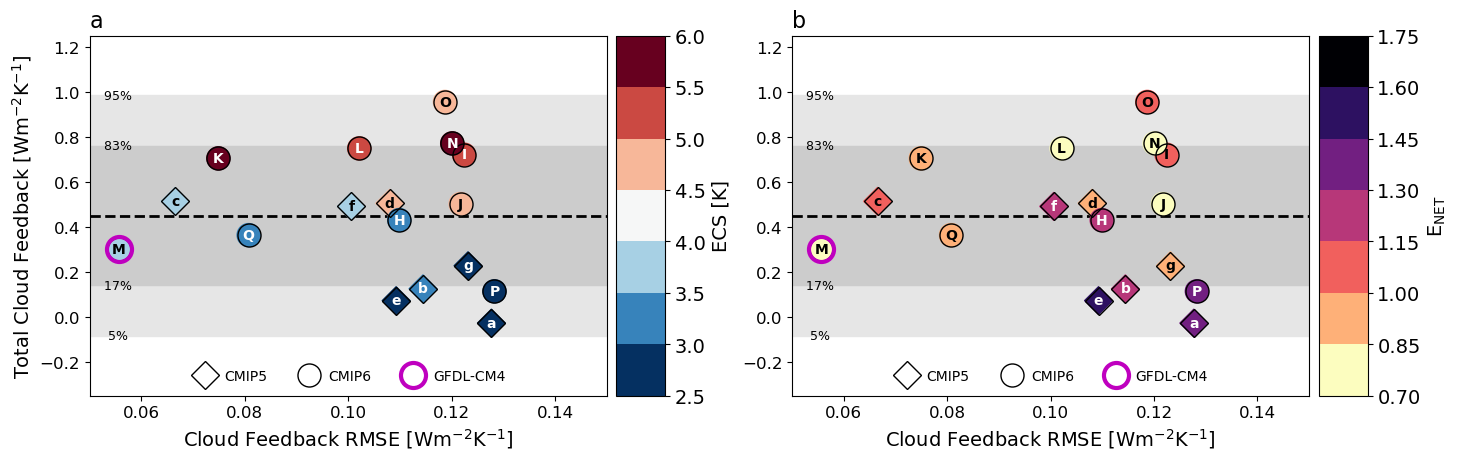

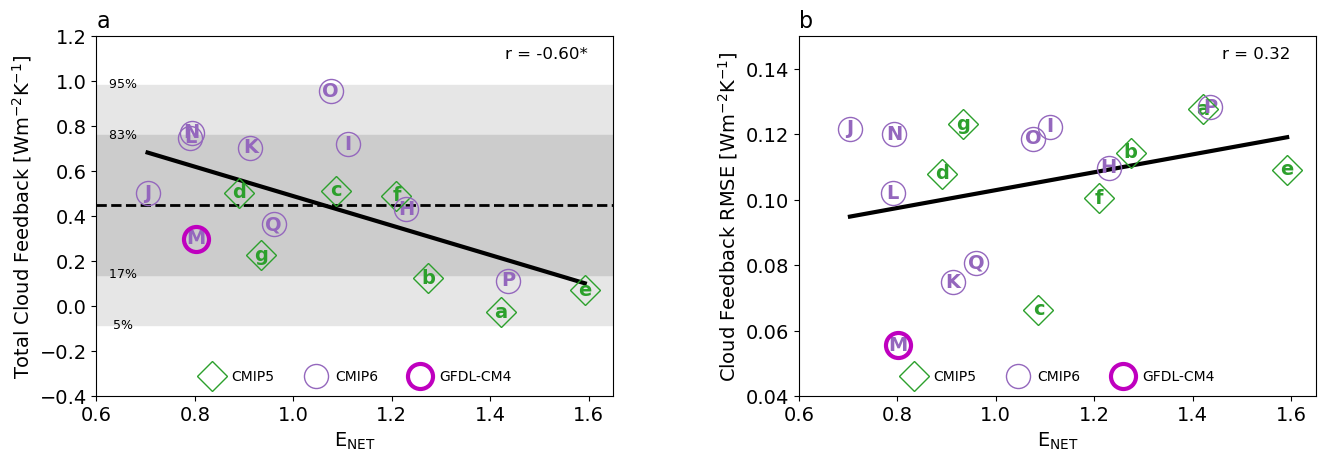

In [7]:
result = dataviz.make_all_figs(updated_fbk_dict,updated_obsc_fbk_dict,updated_err_dict,updated_ecs_dict,model)